In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib nbagg
import librosa
import jams
import librosa.display
import jams.display
import scipy
import resampy
from IPython.display import Audio

import mir_eval

import pandas as pd

In [2]:
def selfsim(x, metric='sqeuclidean'):
    
    D = scipy.spatial.distance.cdist(x.T, x.T, metric=metric)
    bw = np.mean(np.median(D, axis=1))
    
    return np.exp(-D / bw)

def simsim(A, B):
    '''Calculates the cross-correlation between two square matrices A and B'''
    n = min(len(A), len(B))
    
    A = A[:n, :n] - np.mean(A[:n, :n])
    B = B[:n, :n] - np.mean(B[:n, :n])
    
    anorm = np.sqrt(np.sum(A[:n,:n]**2))
    bnorm = np.sqrt(np.sum(B[:n,:n]**2))
    
    return np.sum(A[:n, :n] * B[:n, :n]) / (anorm * bnorm)

In [3]:
#idx, a1, a2 = 'Isophonics_07_-_Maggie_Mae', 'Evan S. Johnson', 'Shuli Tang'

#idx, a1, a2 = 'SALAMI_838', 'John Turner', 'Evan S. Johnson'
#idx, a1, a2 = 'SALAMI_546', 'John Turner', 'Shuli Tang'
#idx, a1, a2 = 'SALAMI_838', 'Eleni Vasilia Maltas', 'Evan S. Johnson'
#idx, a1, a2 = 'SALAMI_1482','Eleni Vasilia Maltas', 'Shuli Tang'
#idx, a1, a2 = 'Cerulean_Boston_Symphony_Orchestra_&_Charles_Munch-Sympho', 'Colin Hua', 'Evan S. Johnson'
#idx, a1, a2 = 'SALAMI_1072', 'Eleni Vasilia Maltas', 'Shuli Tang'
#idx, a1, a2 = 'SALAMI_20', 'John Turner', 'Shuli Tang'
idx, a1, a2 = 'SALAMI_478', 'John Turner', 'Shuli Tang'

In [4]:
#y, sr = librosa.load()
audfile = '/home/bmcfee/data/SPAM/SPAM_{}.mp3'.format(idx)
j = jams.load('/home/bmcfee/git/segment_hierarchy_labels/data/SPAM/{}.jams'.format(idx), validate=False)

features = np.load('/home/bmcfee/git/segment_hierarchy_labels/data/features/SPAM/SPAM_{}.mp3.npz'.format(idx))

ann1 = j.annotations['multi'].search(name=a1)[0]
ann2 = j.annotations['multi'].search(name=a2)[0]


In [25]:
#idx = 220
#idx = 36
#idx = 14
#idx = 254
#idx = 923
#idx = 775
#idx = 636
#idx = 1231
#idx = 410
#idx = 250
#idx = 485
#idx = 781
#idx = 1231 # biggest delta score, smallest L-measure after NCE filtering
idx = 160 # *** second largest delta, post NCE filtering -- interesting one to look at
#idx = 942
#idx = 1295
#idx = 946
#idx = 861 # Smallish l-measure, small delta
#idx = 374 # smallest L-measure
#idx = 19
#idx = 1023
#idx = 1106
#idx = 557
#idx = 163
#idx = 410
#idx = 552
#idx = 768 # also small L-measure
#idx = 485 # also small L-measure
#idx = 624 # small L-measure, informative hierarchy ## makes a pretty good plot
#idx = 427 # jazz track
#idx = 946 # small L-measure, small delta # similar in feature space, just different interpreations of hierarchy
#idx = 405 # small L-measure, smallish delta # turntablism -- total mess
#idx = 188 # small L, smallish delta # solo piano
#idx = 436 # small L, smallish delta
#idx = 410 # small l-measure, high delta, informative hierarchy ## good plot
#idx = 280 # intermediate L, high delta ## pretty good plot
#idx = 36
#idx = 467 # middle of the pack
#idx = 886 # also middle of the pack
#idx = 1362 # middle
#idx = 1456 # middle
#idx = 116 #middle
#idx = 493 # *** middle -- interesting one for an expert to look at; different form structures, not clear how they relate to audio
#idx = 45 # small L, small delta ; blues, looks very similar, but discrepancies come from a-vs-a'
#idx = 104 # high L, middle delta
#idx = 854 # high L middle delta
#idx = 10 # L = 0.5, delta = 0.38 # cure, structure is totally different
#idx = 994
#idx = 936 # high delta, middle/low-L ; ** another good candidate for plotting

#idx = 582 # no hierarchical content
#idx = 1318
#idx = 485
#idx = 188
#idx = 160



#idx = 410 # high delta
#idx = 1290 # also high delta
#idx = 479 # low delta, low l-measure
#idx =12 # low delta, low l-measure
idx = 410
#idx = 878 # ridiculously long track

In [26]:
#y, sr = librosa.load()
audfile = '/home/bmcfee/data/salami-data-public/audio/{}/audio.mp3'.format(idx)

j = jams.load('/home/bmcfee/git/segment_hierarchy_labels/data/SALAMI/{}.jams'.format(idx))

features = np.load('/home/bmcfee/git/segment_hierarchy_labels/data/features/SALAMI/{}.npz'.format(idx))

a1, a2 = 0, 1
ann1 = j.annotations['multi', 0]
ann2 = j.annotations['multi', 1]

In [27]:
h1_ints, h1_labs = jams.eval.hierarchy_flatten(ann1)
h2_ints, h2_labs = jams.eval.hierarchy_flatten(ann2)

In [28]:
L1 = np.asarray(mir_eval.hierarchy._meet(h1_ints, h1_labs, 0.25).todense())
L2 = np.asarray(mir_eval.hierarchy._meet(h2_ints, h2_labs, 0.25).todense())

In [29]:
n = L1.shape[1]

In [30]:
D_tempo = selfsim(features['tempo'])
D_rhythm = selfsim(librosa.logamplitude(features['rhythm']**2, ref_power=np.max))
D_chroma = selfsim(features['chroma'])
D_mfcc = selfsim(features['mfcc'])

In [31]:
v1 = np.asarray([simsim(L1, B) for B in [D_tempo, D_rhythm, D_chroma, D_mfcc]])
v2 = np.asarray([simsim(L2, B) for B in [D_tempo, D_rhythm, D_chroma, D_mfcc]])

agreement = pd.DataFrame(columns=['Tempo', 'Rhythm', 'Chroma', 'MFCC'], data=[v1, v2], index=['A1', 'A2'])

In [32]:
Z = np.zeros((4,4))

for ix, D1 in enumerate([D_tempo, D_rhythm, D_chroma, D_mfcc]):
    for iy, D2 in enumerate([D_tempo, D_rhythm, D_chroma, D_mfcc]):
        Z[ix,iy] = simsim(D1, D2)

<IPython.core.display.Javascript object>


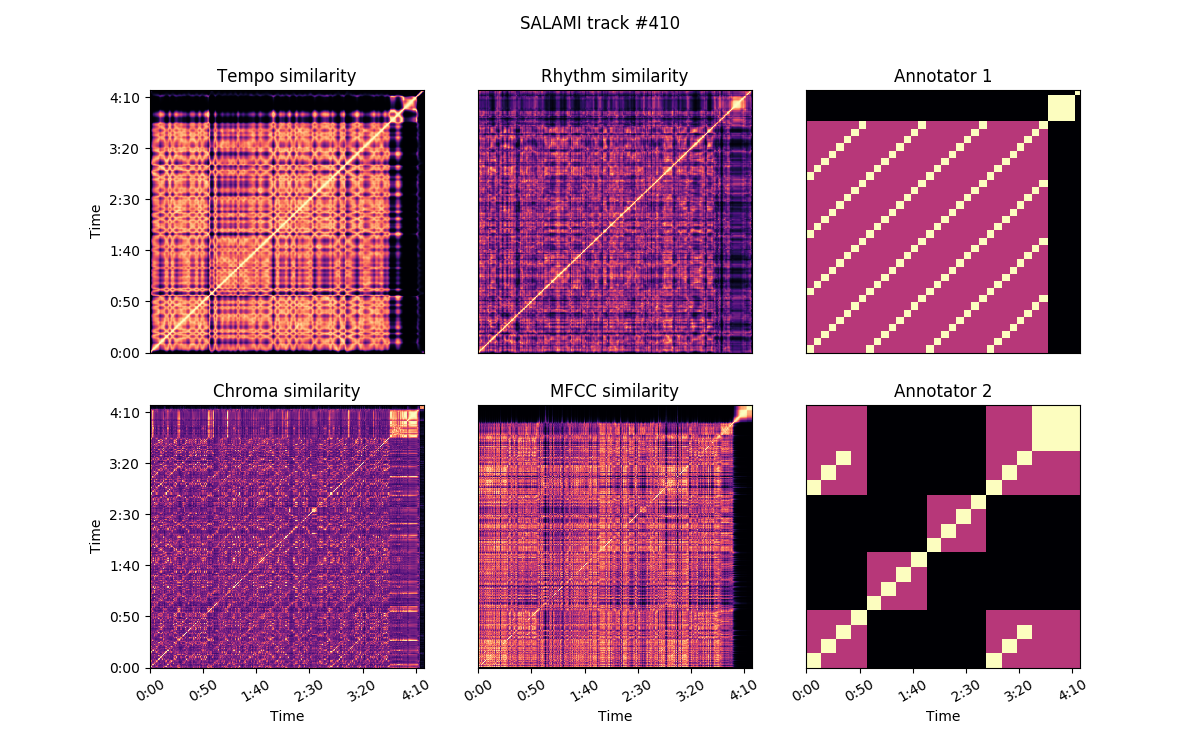

In [33]:
fig = plt.figure(figsize=(12, 7.5))
ax = plt.subplot(2,3,1)
librosa.display.specshow(D_tempo,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.title('Tempo similarity')
plt.xlabel('')
ax.xaxis.set_visible(False)

ax2 = plt.subplot(2,3,2, sharex=ax, sharey=ax)
librosa.display.specshow(D_rhythm,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.ylabel('')
plt.xlabel('')
plt.title('Rhythm similarity')
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)

ax3 = plt.subplot(2,3,4, sharex=ax, sharey=ax)
librosa.display.specshow(D_chroma,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.title('Chroma similarity')
ax3.xaxis.set_ticklabels(ax3.get_xticklabels(), rotation=30)


ax4 = plt.subplot(2,3,5, sharex=ax, sharey=ax)
librosa.display.specshow(D_mfcc,
                         x_axis='time', y_axis='time', sr=4, hop_length=1)
plt.ylabel('')
#plt.xlabel('')
plt.title('MFCC similarity')

ax4.yaxis.set_visible(False)
ax4.xaxis.set_ticklabels(ax4.get_xticklabels(), rotation=30)

ax5 = plt.subplot(2,3,3, sharex=ax, sharey=ax)
librosa.display.specshow(L1, x_axis='time', y_axis='time', sr=4, hop_length=1, cmap='magma')
plt.title('Annotator 1')
plt.xlabel('')
plt.ylabel('')

ax5.xaxis.set_visible(False)
ax5.yaxis.set_visible(False)


ax6 = plt.subplot(2,3,6, sharex=ax, sharey=ax)
ax6.xaxis.set_ticklabels(ax6.xaxis.get_ticklabels(), rotation=30)
librosa.display.specshow(L2, x_axis='time', y_axis='time', sr=4, hop_length=1, cmap='magma')


plt.ylabel('')
ax6.yaxis.set_visible(False)
plt.title('Annotator 2')


                         
plt.suptitle('SALAMI track #{}'.format(idx))
#plt.tight_layout()


In [34]:
plt.savefig('/home/bmcfee/git/segment_hierarchy_labels_paper/figures/feature_correlation_{}.pdf'.format(idx))

In [12]:
agreement

Tempo    Rhythm    Chroma      MFCC
A1  0.618185  0.422022  0.255527  0.484128
A2  0.025016  0.074512  0.069313  0.035821

In [30]:
fig.savefig('../data/figures/feature_correlation_{}.png'.format(idx), pad_inches=0, dpi=600)

In [72]:
Audio(filename=audfile)

print('Colored score: {:.3f}'.format(np.sqrt(np.sum((v1-v2)**2))))

In [13]:
print('Whitened score: {:.3f}'.format( np.sqrt((v1 - v2).dot(np.linalg.inv(Z).dot(v1 - v2)))))

Whitened score: 0.618


In [7]:
j_est = jams.load('../data/estimations/SALAMI/878.jams')

<IPython.core.display.Javascript object>


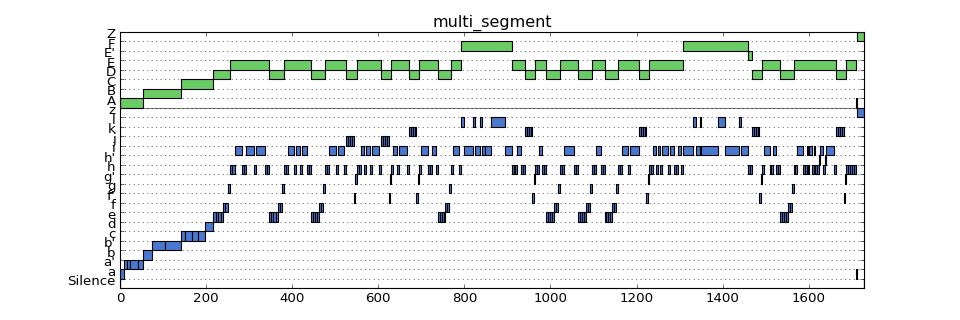

(<matplotlib.figure.Figure at 0x7fa5510c4470>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7fa551438ac8>])

In [9]:
jams.display.display_multi(j.annotations['multi'], meta=False, fig_kw=dict(figsize=(12,4)))
#jams.display.display_multi([ann1, ann2], meta=False, fig_kw=dict(figsize=(12,4)))

<IPython.core.display.Javascript object>


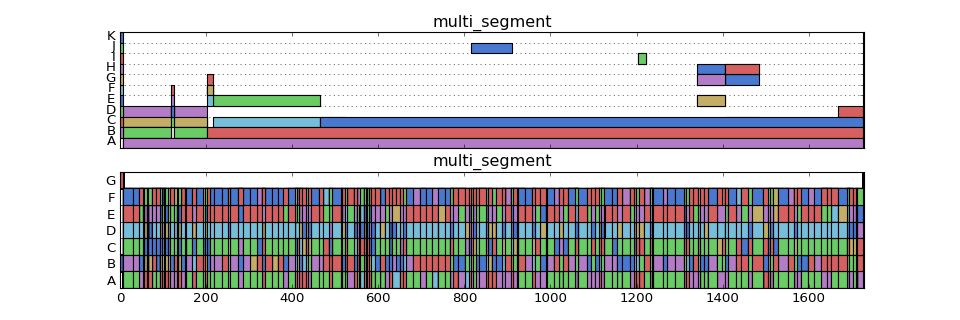

(<matplotlib.figure.Figure at 0x7fa596499048>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5510c67b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa5516d36a0>], dtype=object))

In [12]:
jams.display.display_multi(j_est.annotations['multi'], meta=False, fig_kw=dict(figsize=(12,4)))

---
# Make the whitening matrices

In [ ]:
assert False

In [53]:
from tqdm import tqdm_notebook as tqdm
import os

In [54]:
def compute_z(npz):
    
    features = np.load(npz)
    
    Z = np.zeros((4,4))

    for ix, D1 in enumerate([D_tempo, D_rhythm, D_chroma, D_mfcc]):
        for iy, D2 in enumerate([D_tempo, D_rhythm, D_chroma, D_mfcc]):
            Z[ix,iy] = simsim(D1, D2)
            
    return Z

In [55]:
files_salami = jams.util.find_with_extension('../data/features/SALAMI/', 'npz')

z_salami = {os.path.basename(f): compute_z(f) for f in tqdm(files_salami)}

In [ ]:
np.savez('../data/feature_basis_correlation_salami.npz', **z_salami)

In [17]:
files_spam = jams.util.find_with_extension('../data/features/SPAM/', 'npz')

z_spam = {os.path.basename(f): compute_z(f) for f in tqdm(files_spam)}

In [18]:
np.savez('../data/feature_basis_correlation_spam.npz', **z_spam)